# ML algorithm spot check 

Table of Contents
1. [Read in cleaned data](#cleaned)
1. [Spot check ARIMA](#arima)
1. [Spot check XGBoost](#xgboost)
1. [Spot check CNN](#cnn)

## Read in the cleansed data <a name="cleaned"></a>

In [1]:
import pandas as pd
import numpy as np
import sklearn

In [2]:
prepared_data_dir = 'data/processed'

In [3]:
processed = pd.read_pickle("{}/cooked_v3.pkl".format (prepared_data_dir))

In [ ]:
processed.info ()

In [ ]:
processed.sample(5)

In [183]:
processed.head (5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic
CalcDateTime,,,,,,,,,,,,,,
2017-08-01 08:00:00,15.130,15.135,15.125,15.130,25775.0,29.0,8,0,480,1,213,8,31,DBK
2017-08-01 08:01:00,15.125,15.135,15.115,15.130,25212.0,20.0,8,1,481,1,213,8,31,DBK
2017-08-01 08:02:00,15.130,15.155,15.130,15.150,156268.0,107.0,8,2,482,1,213,8,31,DBK
2017-08-01 08:03:00,15.145,15.155,15.140,15.150,67265.0,43.0,8,3,483,1,213,8,31,DBK
2017-08-01 08:04:00,15.150,15.155,15.140,15.155,20731.0,20.0,8,4,484,1,213,8,31,DBK


In [4]:
selected = processed[processed['Mnemonic'].isin(['EOAN', 'BMW', 'SAP'])]
selected.Mnemonic.cat.remove_unused_categories (inplace=True)

In [185]:
selected.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic
CalcDateTime,,,,,,,,,,,,,,
2017-08-01 08:00:00,8.439,8.445,8.431,8.431,10722.0,22.0,8,0,480,1,213,8,31,EOAN
2017-08-01 08:01:00,8.425,8.427,8.422,8.427,11436.0,16.0,8,1,481,1,213,8,31,EOAN
2017-08-01 08:02:00,8.423,8.426,8.423,8.425,8513.0,11.0,8,2,482,1,213,8,31,EOAN
2017-08-01 08:03:00,8.424,8.424,8.417,8.421,8811.0,10.0,8,3,483,1,213,8,31,EOAN
2017-08-01 08:04:00,8.422,8.422,8.415,8.415,4713.0,8.0,8,4,484,1,213,8,31,EOAN


## Forecast with ARIMA <a name="arima"></a>

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
eoan_data = processed.loc[processed['Mnemonic'] == 'EOAN']
eoan_data = eoan_data.loc[:,'MinPrice':'NumberOfTrades']
eoan_data.head (5)

In [ ]:
eoan_target = eoan_data.MaxPrice.shift (-1)

In [ ]:
eoan_target.fillna(method='ffill', inplace=True)

In [ ]:
eoan_target.tail(5)

In [ ]:
eoan_target.head(5)

In [ ]:
eoan_target.index

In [ ]:
model = ARIMA (eoan_target, order = (15,1,0), dates=eoan_target.index)
model_fit = model.fit (disp=0)
print (model_fit.summary ())

## Forecast with XGBoost <a name="xgboost"></a>

In [186]:
import xgboost

In [187]:
def create_xgb_target (df):
    return df.MaxPrice.shift(-1).fillna (method='ffill')

In [188]:
def create_xgb_features (df, horizon):
    n_df = df.copy ()
    
    for offset in range(1, horizon+1):
        min_price = n_df['MinPrice'].shift (offset).fillna(method='bfill')
        max_price = n_df['MaxPrice'].shift (offset).fillna(method='bfill')
        start_price = n_df['StartPrice'].shift (offset).fillna(method='bfill')
        end_price = n_df['EndPrice'].shift (offset).fillna(method='bfill')
        trade_vol = n_df['TradedVolume'].shift (offset).fillna(method='bfill')
        num_trades = n_df['NumberOfTrades'].shift (offset).fillna(method='bfill')
        
        n_df["h{}_MinPrice".format (offset)] = min_price
        n_df["h{}_MaxPrice".format (offset)] = max_price
        n_df["h{}_StartPrice".format (offset)] = start_price
        n_df["h{}_EndPrice".format (offset)] = end_price
        n_df["h{}_TradeVolume".format (offset)] = trade_vol
        n_df["h{}_NumberOfTrades".format (offset)] = num_trades
        
    return n_df

In [228]:
xgb_data = create_xgb_features (selected, 5)
xgb_data['NextMaxPrice'] = create_xgb_target (xgb_data)
pd.options.display.max_columns=150
xgb_data.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,Mnemonic,h1_MinPrice,h1_MaxPrice,h1_StartPrice,h1_EndPrice,h1_TradeVolume,h1_NumberOfTrades,h2_MinPrice,h2_MaxPrice,h2_StartPrice,h2_EndPrice,h2_TradeVolume,h2_NumberOfTrades,h3_MinPrice,h3_MaxPrice,h3_StartPrice,h3_EndPrice,h3_TradeVolume,h3_NumberOfTrades,h4_MinPrice,h4_MaxPrice,h4_StartPrice,h4_EndPrice,h4_TradeVolume,h4_NumberOfTrades,h5_MinPrice,h5_MaxPrice,h5_StartPrice,h5_EndPrice,h5_TradeVolume,h5_NumberOfTrades,NextMaxPrice
CalcDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-01 08:00:00,8.439,8.445,8.431,8.431,10722.0,22.0,8,0,480,1,213,8,31,EOAN,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.427
2017-08-01 08:01:00,8.425,8.427,8.422,8.427,11436.0,16.0,8,1,481,1,213,8,31,EOAN,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.426
2017-08-01 08:02:00,8.423,8.426,8.423,8.425,8513.0,11.0,8,2,482,1,213,8,31,EOAN,8.422,8.427,8.425,8.427,11436.0,16.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.424
2017-08-01 08:03:00,8.424,8.424,8.417,8.421,8811.0,10.0,8,3,483,1,213,8,31,EOAN,8.423,8.426,8.423,8.425,8513.0,11.0,8.422,8.427,8.425,8.427,11436.0,16.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.422
2017-08-01 08:04:00,8.422,8.422,8.415,8.415,4713.0,8.0,8,4,484,1,213,8,31,EOAN,8.417,8.424,8.424,8.421,8811.0,10.0,8.423,8.426,8.423,8.425,8513.0,11.0,8.422,8.427,8.425,8.427,11436.0,16.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.431,8.445,8.439,8.431,10722.0,22.0,8.421


In [229]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split (xgb_data, train_size=0.8, shuffle=False)
train_data, validate_data = train_test_split (train_data, train_size=0.8, test_size=0.2, shuffle=True)

train_labels = train_data.NextMaxPrice
validate_labels = validate_data.NextMaxPrice
test_labels = test_data.NextMaxPrice

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [230]:
train_data.drop ("NextMaxPrice", axis=1, inplace=True)
validate_data.drop ("NextMaxPrice", axis=1, inplace=True)
test_data.drop ('NextMaxPrice', axis = 1, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [231]:
train_features = pd.get_dummies(train_data)
validate_features = pd.get_dummies(validate_data)
test_features = pd.get_dummies(test_data)
train_features.head(5)

,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,NumberOfTrades,HourOfDay,MinOfHour,MinOfDay,DayOfWeek,DayOfYear,MonthOfYear,WeekOfYear,h1_MinPrice,h1_MaxPrice,h1_StartPrice,h1_EndPrice,h1_TradeVolume,h1_NumberOfTrades,h2_MinPrice,h2_MaxPrice,h2_StartPrice,h2_EndPrice,h2_TradeVolume,h2_NumberOfTrades,h3_MinPrice,h3_MaxPrice,h3_StartPrice,h3_EndPrice,h3_TradeVolume,h3_NumberOfTrades,h4_MinPrice,h4_MaxPrice,h4_StartPrice,h4_EndPrice,h4_TradeVolume,h4_NumberOfTrades,h5_MinPrice,h5_MaxPrice,h5_StartPrice,h5_EndPrice,h5_TradeVolume,h5_NumberOfTrades,Mnemonic_BMW,Mnemonic_EOAN,Mnemonic_SAP
CalcDateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-14 14:47:00,80.540,80.560,80.540,80.560,496.0,6.0,14,47,887,0,226,8,33,80.530,80.580,80.560,80.540,1580.0,17.0,80.520,80.560,80.550,80.530,5673.0,29.0,80.490,80.550,80.490,80.540,1898.0,15.0,80.49,80.540,80.490,80.500,3282.0,24.0,80.470,80.490,80.470,80.480,2027.0,15.0,1,0,0
2017-08-01 13:55:00,90.400,90.430,90.390,90.430,4522.0,25.0,13,55,835,1,213,8,31,90.400,90.430,90.430,90.410,2566.0,21.0,90.400,90.440,90.440,90.410,1012.0,9.0,90.400,90.450,90.410,90.440,3494.0,21.0,90.41,90.450,90.420,90.410,8224.0,33.0,90.410,90.450,90.450,90.420,1988.0,26.0,0,0,1
2017-08-03 15:41:00,90.480,90.510,90.460,90.500,0.0,0.0,15,41,941,3,215,8,31,90.460,90.510,90.480,90.500,0.0,0.0,90.460,90.510,90.480,90.500,0.0,0.0,90.460,90.510,90.480,90.500,0.0,0.0,90.46,90.510,90.480,90.500,0.0,0.0,90.460,90.510,90.480,90.500,0.0,0.0,0,0,1
2017-08-15 11:04:00,89.860,89.870,89.850,89.850,600.0,5.0,11,4,664,1,227,8,33,89.830,89.850,89.850,89.850,1672.0,14.0,89.850,89.930,89.920,89.850,2510.0,14.0,89.880,89.900,89.880,89.900,0.0,0.0,89.88,89.900,89.880,89.900,0.0,0.0,89.880,89.900,89.880,89.900,807.0,4.0,0,0,1
2017-08-04 09:41:00,8.707,8.707,8.707,8.707,14622.0,8.0,9,41,581,4,216,8,31,8.703,8.712,8.705,8.709,38121.0,33.0,8.704,8.706,8.706,8.705,23176.0,18.0,8.703,8.708,8.703,8.707,21518.0,22.0,8.70,8.705,8.703,8.701,27038.0,42.0,8.695,8.705,8.696,8.703,55085.0,35.0,0,1,0


In [193]:
model = xgboost.XGBRegressor (n_estimators=500)
model.fit (train_features, train_labels, 
           eval_set=[(train_features, train_labels), (validate_features, validate_labels)],
           early_stopping_rounds = 50, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

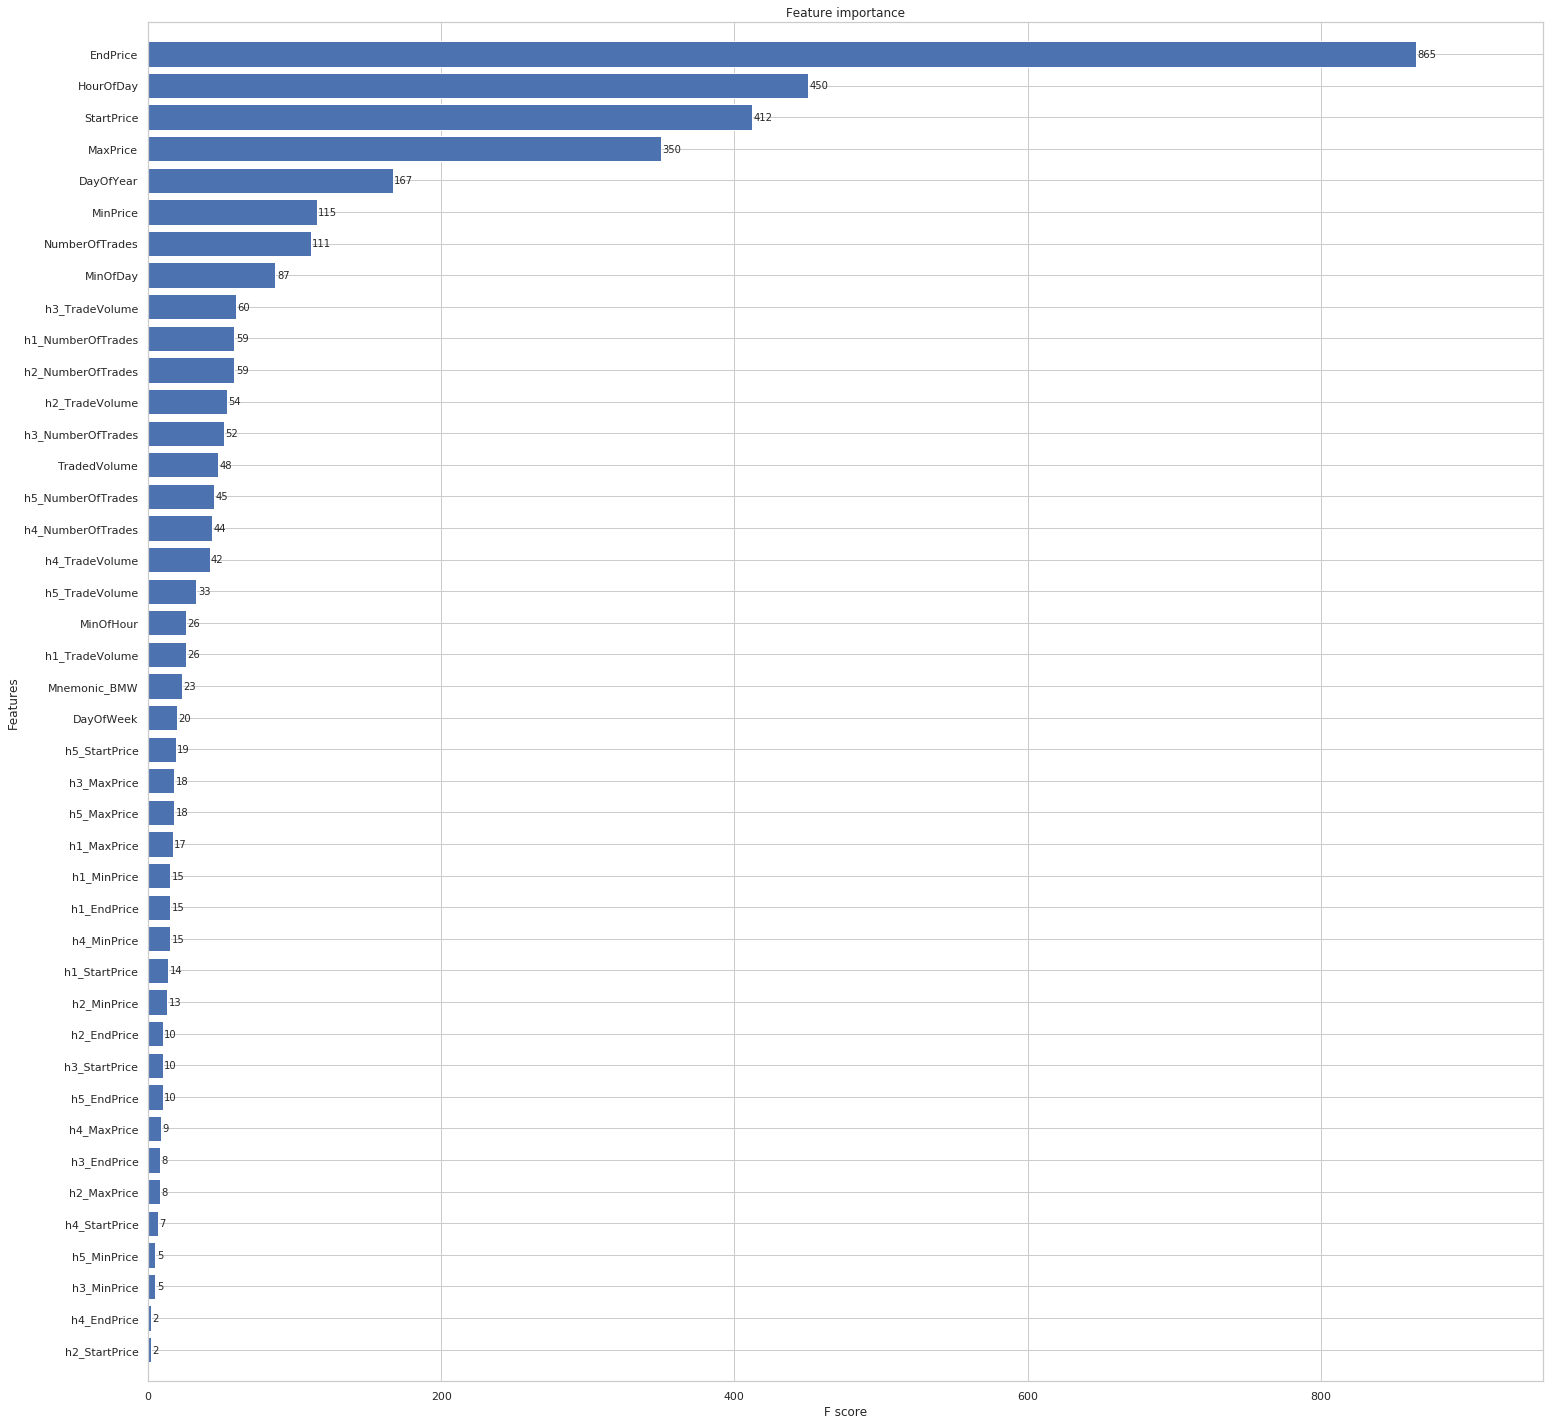

In [194]:
%matplotlib inline
from matplotlib import pyplot as plt
from xgboost import plot_importance
fig, ax = plt.subplots(1,1,figsize=(25,25))
plot_importance(model, height=0.8, ax=ax)

In [195]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = model.predict (test_features)
print ("RMSE: {}".format (mean_squared_error (y_true = test_labels, y_pred = pred)))
print ("MAE: {}".format (mean_absolute_error (y_true = test_labels, y_pred = pred)))

RMSE: 0.06960399715992382
MAE: 0.03436020868862223


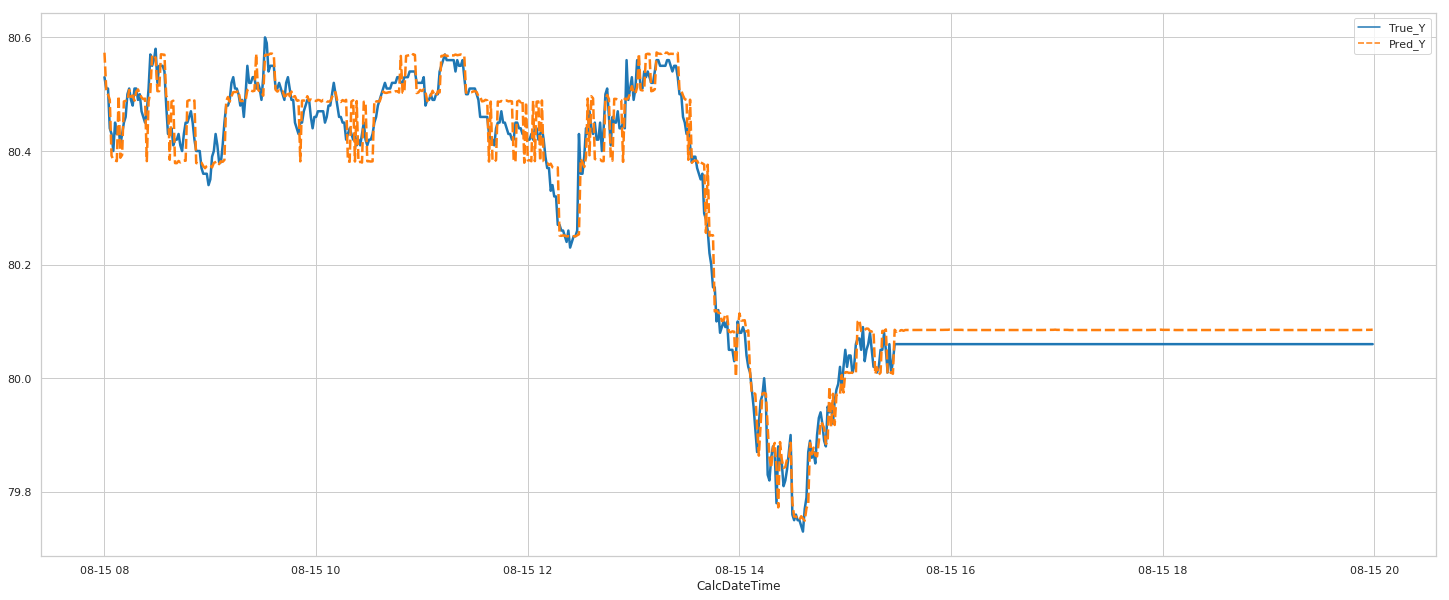

In [196]:
import seaborn as sns
from matplotlib import pyplot as plt

start_loc = test_labels.index.get_loc('2017-08-15 08:00:00')
end_loc = test_labels.index.get_loc('2017-08-15 20:00:00')
data = pd.DataFrame ()
data['True_Y'] = test_labels[start_loc:end_loc]
data['Pred_Y'] = pred[start_loc:end_loc]

fig, ax = plt.subplots(figsize=(25,10))
sns.set(style='whitegrid')
sns.lineplot (data = data, palette='tab10', linewidth=2.5, ax=ax)

## Forecasting with an MLP

In [213]:
import mxnet as mx
from mxnet import nd, autograd, gluon

In [279]:
num_hidden_1 = 64
num_hidden_2 = 24
num_output = 1
learning_rate = 0.001
batch_size = 100
num_examples = 33233

model_ctx = mx.cpu ()
data_ctx = mx.cpu ()

In [280]:
train_dataset = gluon.data.dataset.ArrayDataset (nd.array(train_features), nd.array(train_labels))
train_dataloader = gluon.data.DataLoader (train_dataset, batch_size=batch_size)

validate_dataset = gluon.data.dataset.ArrayDataset (nd.array(validate_features), nd.array(validate_labels))
validate_dataloader = gluon.data.DataLoader (validate_dataset, batch_size=batch_size)

test_dataset = gluon.data.dataset.ArrayDataset (nd.array(test_features), nd.array(test_labels))
test_dataloader = gluon.data.DataLoader (test_dataset, batch_size=batch_size)

In [281]:
model = gluon.nn.Sequential ()
with model.name_scope ():
    model.add (gluon.nn.Dense (num_hidden_1, activation='relu'))
    model.add (gluon.nn.Dense (num_hidden_2, activation='relu'))
    model.add (gluon.nn.Dense (num_output))
    
model.collect_params().initialize(mx.init.Normal(sigma=.1), ctx=model_ctx)
l2loss = gluon.loss.L2Loss ()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': learning_rate})


In [277]:
def evaluate_accuracy(data_iterator, model):
    rmse = mx.metric.RMSE ()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).reshape((-1, 46))
        label = label.as_in_context(model_ctx)
        output = model(data)
        predictions = output # predictions = nd.argmax(output, axis=1)
        rmse.update(preds=predictions, labels=label)
    return rmse.get()[1]

In [282]:
epochs = 50
smoothing_constant = .01

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_dataloader):
        data = data.as_in_context(model_ctx).reshape((-1, 46))
        label = label.as_in_context(model_ctx)
        with autograd.record():
            output = model(data)
            loss = l2loss(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        cumulative_loss += nd.sum(loss).asscalar()

    validate_accuracy = evaluate_accuracy(validate_dataloader, model)
    train_accuracy = evaluate_accuracy(train_dataloader, model)
    print("Epoch %s. Loss: %s, Train_acc %s, Validate_acc %s" %
          (e, cumulative_loss/num_examples, train_accuracy, validate_accuracy))

Epoch 0. Loss: 3149.76213314, Train_acc 57.5516029163, Validate_acc 62.0220948089
Epoch 1. Loss: 1100.6049364, Train_acc 19.5572516009, Validate_acc 21.4783893043
Epoch 2. Loss: 263.36653804, Train_acc 19.1980988041, Validate_acc 19.7767674951
Epoch 3. Loss: 402.414721587, Train_acc 21.774563228, Validate_acc 22.6614381586
Epoch 4. Loss: 408.259328886, Train_acc 10.2773647201, Validate_acc 10.6611200458
Epoch 5. Loss: 643.760835243, Train_acc 9.99133571633, Validate_acc 9.91570827223
Epoch 6. Loss: 255.694455926, Train_acc 9.24582110869, Validate_acc 10.0240922712
Epoch 7. Loss: 35.9043618579, Train_acc 7.10117590034, Validate_acc 7.69196082013
Epoch 8. Loss: 22.7039173418, Train_acc 6.37762421459, Validate_acc 6.7749481116
Epoch 9. Loss: 37.537917004, Train_acc 7.15206671978, Validate_acc 7.61750059362
Epoch 10. Loss: 29.9880591885, Train_acc 6.16185992186, Validate_acc 6.46600986911
Epoch 11. Loss: 192.518640864, Train_acc 6.34543718912, Validate_acc 6.46047314256
Epoch 12. Loss: 139

In [283]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = model(nd.array(test_features)).asnumpy ().reshape(-1)
print ("RMSE: {}".format (mean_squared_error (y_true = test_labels, y_pred = pred)))
print ("MAE: {}".format (mean_absolute_error (y_true = test_labels, y_pred = pred)))

RMSE: 0.07960017799251666
MAE: 0.1363286157560453


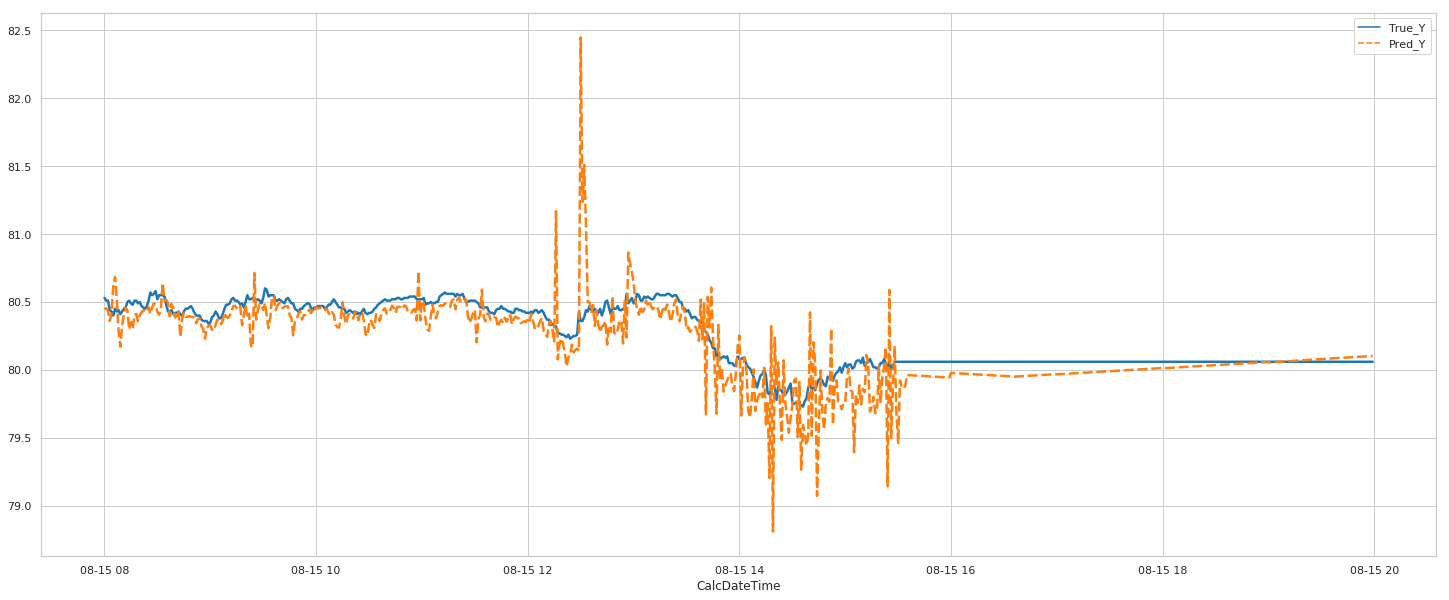

In [284]:
import seaborn as sns
from matplotlib import pyplot as plt

start_loc = test_labels.index.get_loc('2017-08-15 08:00:00')
end_loc = test_labels.index.get_loc('2017-08-15 20:00:00')
data = pd.DataFrame ()
data['True_Y'] = test_labels[start_loc:end_loc]
data['Pred_Y'] = pred[start_loc:end_loc]

fig, ax = plt.subplots(figsize=(25,10))
sns.set(style='whitegrid')
sns.lineplot (data = data, palette='tab10', linewidth=2.5, ax=ax)

## Forecasting with CNN <a name="cnn"></a>

https://machinelearningmastery.com/how-to-develop-convolutional-neural-networks-for-multi-step-time-series-forecasting/

In [5]:
from datetime import timedelta

def create_cnn_data (df, horizon):
    mnemonics = df.Mnemonic.unique()
    timestamps = df.index.unique()
    
    days = (df.index[-1] - df.index[0]).days
    row_count = len(mnemonics)*days*(12*60 - horizon)

    one_hot_data = pd.get_dummies(df)

    features = np.empty((row_count, horizon, one_hot_data.shape[1]))
    labels = np.empty(row_count)
    
    print ("Mnemonics: {}, days: {}, horizon: {}".format (len(mnemonics), days, horizon))
    print ("Features shape: {}, Labels shape: {}".format (features.shape, labels.shape))

    row_index = 0
    for m in mnemonics:
        m_ticks = one_hot_data[one_hot_data['Mnemonic_{}'.format(m)] == 1]
        print ("Mnemonic {} has {} rows of data".format (m, len(m_ticks)))

        tick_count = len(m_ticks)
        for i in range(tick_count):
            start_ts = m_ticks.iloc[i].name
            end_ts = start_ts + timedelta (minutes = (horizon-1))
            label_ts = start_ts + timedelta (minutes = horizon)

            start_ts_str = start_ts.strftime('%Y-%m-%d %H:%M:%S')
            end_ts_str = end_ts.strftime('%Y-%m-%d %H:%M:%S')
            label_ts_str = label_ts.strftime('%Y-%m-%d %H:%M:%S')

            if label_ts_str in timestamps:
                labels[row_index] = m_ticks.loc[label_ts_str].MaxPrice
                features[row_index] = m_ticks[start_ts_str:end_ts_str].values
                if row_index % 10000 == 0:
                    print ("Row index {}, features shape {}, labels shape {}".format (row_index, features.shape, labels.shape))
                row_index += 1
                        
    return (features, labels)
    

In [6]:
%%time

(cnn_features, cnn_labels) = create_cnn_data (selected, 5)

train_index = int(len(cnn_features)*.6)
test_index = int(len(cnn_features)*.8)

train_features = cnn_features[0:train_index]
validate_features = cnn_features[train_index:test_index]
test_features = cnn_features[test_index:]

train_labels = cnn_labels[:train_index]
validate_labels = cnn_labels[train_index:test_index]
test_labels = cnn_labels[test_index:]
                                              
print (train_features.shape, train_labels.shape)
print (validate_features.shape, validate_labels.shape)
print (test_features.shape, test_labels.shape)

Mnemonics: 3, days: 31, horizon: 5
Features shape: (66495, 5, 16), Labels shape: (66495,)
Mnemonic EOAN has 17304 rows of data
Row index 0, features shape (66495, 5, 16), labels shape (66495,)
Row index 10000, features shape (66495, 5, 16), labels shape (66495,)
Mnemonic SAP has 17304 rows of data
Row index 20000, features shape (66495, 5, 16), labels shape (66495,)
Row index 30000, features shape (66495, 5, 16), labels shape (66495,)
Mnemonic BMW has 17304 rows of data
Row index 40000, features shape (66495, 5, 16), labels shape (66495,)
Row index 50000, features shape (66495, 5, 16), labels shape (66495,)
(39897, 5, 16) (39897,)
(13299, 5, 16) (13299,)
(13299, 5, 16) (13299,)
CPU times: user 2min 45s, sys: 3.75 s, total: 2min 49s
Wall time: 2min 49s


In [200]:
train_features[-1]

array([[   79.88,    79.97,    79.88,    79.91,     0.  ,     0.  ,
           16.  ,    36.  ,   996.  ,     3.  ,   222.  ,     8.  ,
           32.  ,     1.  ,     0.  ,     0.  ],
       [   79.88,    79.97,    79.88,    79.91,     0.  ,     0.  ,
           16.  ,    37.  ,   997.  ,     3.  ,   222.  ,     8.  ,
           32.  ,     1.  ,     0.  ,     0.  ],
       [   79.88,    79.97,    79.88,    79.91,     0.  ,     0.  ,
           16.  ,    38.  ,   998.  ,     3.  ,   222.  ,     8.  ,
           32.  ,     1.  ,     0.  ,     0.  ],
       [   79.88,    79.97,    79.88,    79.91,     0.  ,     0.  ,
           16.  ,    39.  ,   999.  ,     3.  ,   222.  ,     8.  ,
           32.  ,     1.  ,     0.  ,     0.  ],
       [   79.88,    79.97,    79.88,    79.91,     0.  ,     0.  ,
           16.  ,    40.  ,  1000.  ,     3.  ,   222.  ,     8.  ,
           32.  ,     1.  ,     0.  ,     0.  ]])

In [201]:
train_labels[0]

8.4209999999999994

In [7]:
import mxnet as mx
from mxnet import gluon, nd, autograd

In [8]:
ctx = mx.cpu ()

In [12]:
batch_size = 32
num_inputs = 16
num_outputs = 1
num_fc = 100

In [15]:
train_dataset = gluon.data.dataset.ArrayDataset (nd.array(train_features), nd.array(train_labels))
train_dataloader = gluon.data.DataLoader (train_dataset, batch_size=batch_size)

validate_dataset = gluon.data.dataset.ArrayDataset (nd.array (validate_features), nd.array(validate_labels))
validate_dataloader = gluon.data.DataLoader (validate_dataset, batch_size = batch_size)

In [14]:
model = gluon.nn.Sequential ()
with model.name_scope ():
    model.add(gluon.nn.Conv1D(channels=64, kernel_size=3, activation='relu'))
    model.add(gluon.nn.Conv1D(channels=64, kernel_size=3, activation='relu'))
    model.add(gluon.nn.Dropout (0.5))
    model.add(gluon.nn.MaxPool1D(pool_size=2))
    # The Flatten layer collapses all axis, except the first one, into one axis.
    model.add(gluon.nn.Flatten())
    model.add(gluon.nn.Dense(num_fc, activation="relu"))
    model.add(gluon.nn.Dense(num_outputs))
    
model.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': .01})

In [16]:
rmse_loss = gluon.loss.L2Loss ()

In [17]:
def evaluate_accuracy(data_iterator, model):
    rmse = mx.metric.RMSE ()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = model(data)
        predictions = output
        rmse.update(preds=predictions, labels=label)
    return rmse.get()[1]

In [18]:
epochs = 30
smoothing_constant = .01

for e in range(epochs):
    for i, (data, label) in enumerate (train_dataloader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = model(data)
            loss = rmse_loss(output, label)
        loss.backward()
        trainer.step(data.shape[0])

        ##########################
        #  Keep a moving average of the losses
        ##########################
        curr_loss = nd.mean(loss).asscalar()
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                       else (1 - smoothing_constant) * moving_loss + smoothing_constant * curr_loss)

    validate_accuracy = evaluate_accuracy(validate_dataloader, model)
    train_accuracy = evaluate_accuracy(train_dataloader, model)
    print("Epoch %s. Loss: %s, Train_mse %s, Validate_mse %s" % (e, moving_loss, train_accuracy, validate_accuracy))

Epoch 0. Loss: 1076.06854785, Train_mse 62.2144955648, Validate_mse 29.4365753451
Epoch 1. Loss: 876.172382481, Train_mse 40.9382356584, Validate_mse 31.4795076985
Epoch 2. Loss: 15.2353928284, Train_mse 34.8007672594, Validate_mse 11.9381572134
Epoch 3. Loss: 10.0840898916, Train_mse 34.6346019672, Validate_mse 11.3162671539
Epoch 4. Loss: 5.82587812422, Train_mse 34.6162495428, Validate_mse 10.7391863163
Epoch 5. Loss: 3.70032862503, Train_mse 34.5967604184, Validate_mse 10.5012252558
Epoch 6. Loss: 2.68854326363, Train_mse 34.6037753257, Validate_mse 10.3648105179
Epoch 7. Loss: 2.07542312948, Train_mse 34.5795223592, Validate_mse 10.2721045814
Epoch 8. Loss: 11.2358758003, Train_mse 34.6212290162, Validate_mse 10.9657478619
Epoch 9. Loss: 3.58344377362, Train_mse 34.6145099011, Validate_mse 10.8441123613
Epoch 10. Loss: 2.81360249965, Train_mse 34.6097159981, Validate_mse 10.751513904
Epoch 11. Loss: 2.3387007877, Train_mse 34.607281292, Validate_mse 10.6645089701
Epoch 12. Loss: 2

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
pred = model(nd.array (test_features))

In [16]:
pred[0:5], pred[-5:]

(
 [[ 9.63893795]
  [ 9.63893795]
  [ 9.63893795]
  [ 9.63893795]
  [ 9.63893795]]
 <NDArray 5x1 @cpu(0)>, 
 [[ 9.63893795]
  [ 9.63893795]
  [ 9.63893795]
  [ 9.63893795]
  [ 9.63893795]]
 <NDArray 5x1 @cpu(0)>)

In [18]:
test_labels[:5], test_labels[-5:]

(array([  5.43230955e-312,   1.39067124e-309,   7.29112897e-304,
          5.43230955e-312,   1.39067124e-309]),
 array([  5.43230955e-312,   1.39067124e-309,   7.29112897e-304,
          5.43230955e-312,   1.39067124e-309]))

In [17]:
np_pred = pred.asnumpy()
np_pred = np_pred.reshape(np_pred.shape[0])
print ("RMSE: {}".format (mean_squared_error (y_true = test_labels, y_pred = np_pred)))
print ("MAE: {}".format (mean_absolute_error (y_true = test_labels, y_pred = np_pred)))

RMSE: 92.90912480653878
MAE: 9.638937950134277


In [174]:
np_pred[0:10]

array([ 60.78895187,  60.78895187,  60.78895187,  60.78895187,
        60.78895187,  60.78895187,  60.78895187,  60.78895187,
        60.78895187,  60.78895187], dtype=float32)

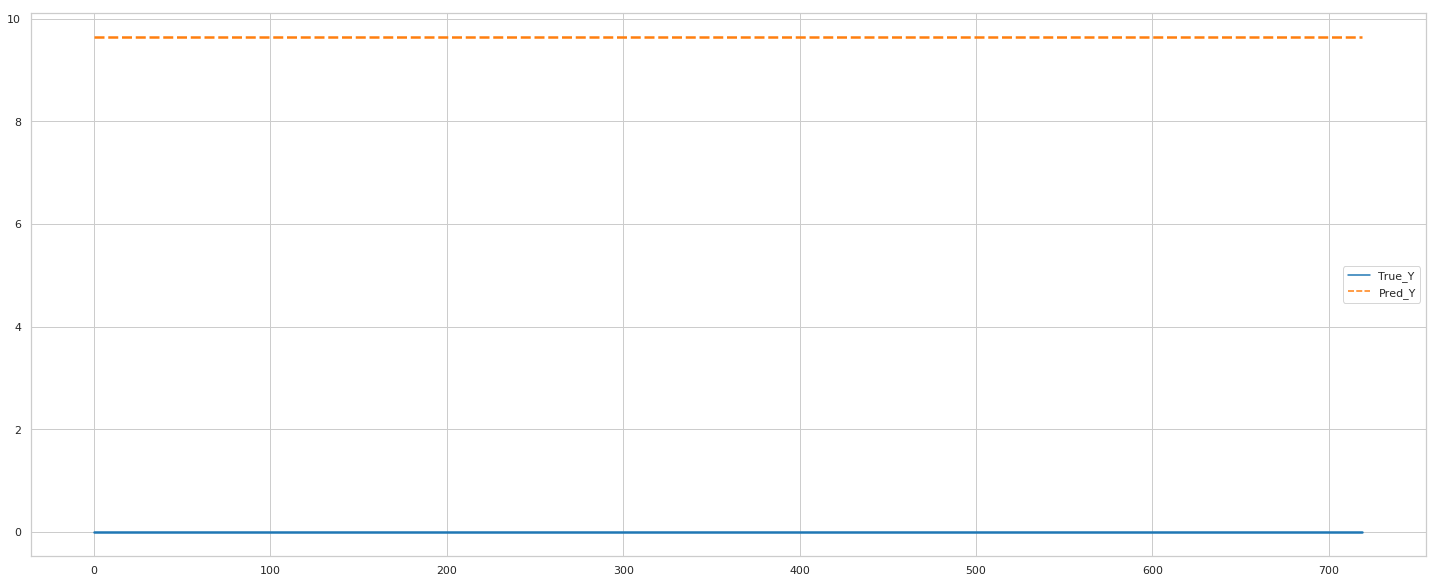

In [20]:
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

start_loc = 0
end_loc = 12*60
data = pd.DataFrame ()
data['True_Y'] = test_labels[start_loc:end_loc]
data['Pred_Y'] = np_pred[start_loc:end_loc]

fig, ax = plt.subplots(figsize=(25,10))
sns.set(style='whitegrid')
sns.lineplot (data = data, palette='tab10', linewidth=2.5, ax=ax)

---
Extra credit

## Forecasting with LSTM

## Forecasting with DeepAR